In [1]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from pyspark.sql.types import IntegerType
from pyspark.sql.types import DateType

from pyspark.sql import functions as func
from pyspark.sql.functions import desc, asc, when, to_date
from pyspark.sql.functions import sum as Fsum

import datetime

import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# Load and Clean Dataset

Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [2]:
user_log = spark.read.json("Udacity Deep Learning/medium-sparkify-event-data.json")
user_log.take(5)

[Row(artist='Martin Orford', auth='Logged In', firstName='Joseph', gender='M', itemInSession=20, lastName='Morales', length=597.55057, level='free', location='Corpus Christi, TX', method='PUT', page='NextSong', registration=1532063507000, sessionId=292, song='Grand Designs', status=200, ts=1538352011000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', userId='293'),
 Row(artist="John Brown's Body", auth='Logged In', firstName='Sawyer', gender='M', itemInSession=74, lastName='Larson', length=380.21179, level='free', location='Houston-The Woodlands-Sugar Land, TX', method='PUT', page='NextSong', registration=1538069638000, sessionId=97, song='Bulls', status=200, ts=1538352025000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"', userId='98'),
 Row(artist='Afroman', auth='Logged In', firstName='Maverick', gender='M', 

In [3]:
user_log.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [4]:
print("Missing user ids: ", user_log.where(user_log.userId.isNull()).count())
print("Missing session ids: ", user_log.where(user_log.sessionId.isNull()).count())

Missing user ids:  0
Missing session ids:  0


In [5]:
# Remove rows with null user ids or session ids
user_log_valid = user_log.dropna(how = "any", subset = ["userId", "sessionId"])
user_log_valid.count()

543705

# Exploratory Data Analysis

Goal is to understand dataset structure, features and distributions, and to define the churn event.

Churn event is defined based on the 'Cancellation Confirmation' event. After the event is defined, we can observe the behavior of groups of users.

<AxesSubplot:xlabel='count', ylabel='page'>

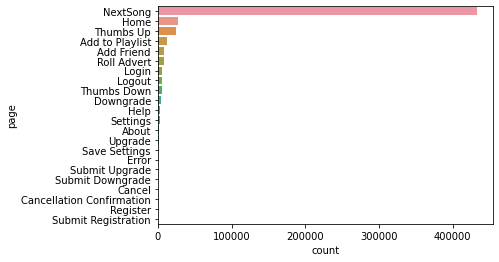

In [9]:
# Distinct type of pages that exist
df = user_log_valid.groupBy("page").count().sort('count', ascending=False).toPandas()
sns.barplot(data = df, x = 'count', y = 'page')

In [10]:
# add churn event to use as target event
flag_churn_event = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())
user_log_valid = user_log_valid.withColumn("churn", flag_churn_event("page"))
user_log_valid.groupBy("churn").count().show()

+-----+------+
|churn| count|
+-----+------+
|    1|    99|
|    0|543606|
+-----+------+



In [11]:
# Since time is recorded in Unix time, we will convert it to python timestamp for convenience 
# and to apply date/time arithmetic later
# udf to convert the ts to timestamp - source https://stackoverflow.com/questions/45977449/convert-timestamp-to-date-in-spark-dataframe

get_timestamp = udf(lambda x : datetime.datetime.fromtimestamp(x/ 1000.0).strftime("%Y-%m-%d %H:%M:%S"))

#apply this udf in the dataframe with the timestamp
user_log_valid = user_log_valid.withColumn("event_ts", get_timestamp(user_log_valid.ts))

In [12]:
# save it in a temp view so it can be used with spark sql manipulations later
user_log_valid.createOrReplaceTempView("log_view")

In [13]:
spark.sql("select churn, count(distinct userId) from log_view group by churn").show()

+-----+----------------------+
|churn|count(DISTINCT userId)|
+-----+----------------------+
|    1|                    99|
|    0|                   449|
+-----+----------------------+



In [14]:
user_log_valid.describe()

DataFrame[summary: string, artist: string, auth: string, firstName: string, gender: string, itemInSession: string, lastName: string, length: string, level: string, location: string, method: string, page: string, registration: string, sessionId: string, song: string, status: string, ts: string, userAgent: string, userId: string, churn: string, event_ts: string]

# Feature Engineering

To continue the EDA, we should aggregate the data on a session and then user levels. In the process, we can also create additional features. Then we can continue the EDA to evaluate the potential correlation between the behavior of the subscribers and the churn event.

In [15]:
# add session level features
# session duration
# number of songs, artists per session, average song length etc. 

user_session_df = spark.sql('''
    select userId, sessionId, count(distinct artist) as session_artist_cnt, 
    count(distinct song) as session_song_cnt, min(event_ts) as start_ts, max(event_ts) as end_ts,
    (max(ts) - min(ts))/3600000  as session_duration_hr, avg(length) as avg_song_length
    from log_view
    where song != 'None'
    group by userId, sessionId''')

user_session_df.createOrReplaceTempView('user_session_view')

In [16]:
user_session_df.printSchema()

root
 |-- userId: string (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- session_artist_cnt: long (nullable = false)
 |-- session_song_cnt: long (nullable = false)
 |-- start_ts: string (nullable = true)
 |-- end_ts: string (nullable = true)
 |-- session_duration_hr: double (nullable = true)
 |-- avg_song_length: double (nullable = true)



In [17]:
# Main set will have user level aggregation - i.e. one row per user
user_df = spark.sql('''
    select a.userId, max(churn) as churn, min(event_ts) as start_dt, max(event_ts) as end_dt, count(*) as views_cnt, 
    count(distinct a.sessionId) as visits_cnt, if(sum(if(level=='paid', 1, 0))>0, 1, 0) as paid,
    count(distinct artist) as all_artists_cnt, datediff(max(event_ts),min(event_ts)) as tenure,
    avg(session_song_cnt) as avg_session_song_cnt, avg(session_duration_hr) as avg_session_duriation_hr,
    avg(avg_song_length) as avg_song_length
    from log_view a
    join user_session_view b on a.userId = b.userId    
    group by a.userId''')
user_df.createOrReplaceTempView('user_view')
user_df.printSchema()

root
 |-- userId: string (nullable = true)
 |-- churn: integer (nullable = true)
 |-- start_dt: string (nullable = true)
 |-- end_dt: string (nullable = true)
 |-- views_cnt: long (nullable = false)
 |-- visits_cnt: long (nullable = false)
 |-- paid: integer (nullable = false)
 |-- all_artists_cnt: long (nullable = false)
 |-- tenure: integer (nullable = true)
 |-- avg_session_song_cnt: double (nullable = true)
 |-- avg_session_duriation_hr: double (nullable = true)
 |-- avg_song_length: double (nullable = true)



In [18]:
user_df.groupBy('churn').count().show()

+-----+-----+
|churn|count|
+-----+-----+
|    1|   99|
|    0|  349|
+-----+-----+



In [19]:
# add counts for each page view by user 
page_views_df = spark.sql('''
    select userId, 
    sum(if(page=='Thumbs Up', 1, 0)) as thumbs_up,
    sum(if(page=='Add to Playlist', 1, 0)) as add_to_playlist,
    sum(if(page=='Add Friend',1,0)) as add_friend,
    sum(if(page=='Thumbs Down',1,0)) as thumbs_down,
    sum(if(page=='Upgrade',1,0)) as upgrade,
    sum(if(page=='Downgrade',1,0)) as downgrade,
    sum(if(page=='Roll Advert',1,0)) as rol_advert,
    sum(if(page=='Help',1,0)) as help, 
    sum(if(page=='Settings',1,0)) as settings
    from log_view 
    group by userId''')
page_views_df.createOrReplaceTempView('page_views')

In [20]:
# add page counts to user dataset 
user_df = spark.sql('''
    select a.*, tenure/visits_cnt as freq, thumbs_up, add_to_playlist, add_friend, thumbs_down, upgrade,
    downgrade, rol_advert, help, settings
    from user_view a
    join page_views b on a.userId = b.userId''')

In [21]:
# Convert to pandas dataframe for EDA
user_df_pd = user_df.toPandas()

In [22]:
user_df_pd['churn'].value_counts(normalize=True)

0    0.779018
1    0.220982
Name: churn, dtype: float64

churn
0    45.985673
1    25.323232
Name: tenure, dtype: float64


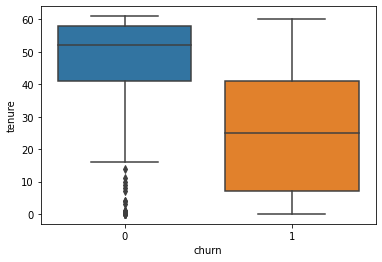

In [23]:
print(user_df_pd.groupby('churn')['tenure'].agg('mean'))
sns.boxplot(x='churn', y='tenure', data=user_df_pd);

Users who ended up churning had 25 months as average tenure vs. users who did not churn had 46 months of tenure.

churn
0    5.115502
1    2.753996
Name: freq, dtype: float64


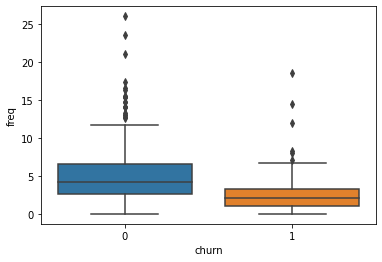

In [26]:
print(user_df_pd.groupby('churn')['freq'].agg('mean'))
sns.boxplot(x='churn', y='freq', data=user_df_pd);

Visit frequency is an engineered feature that shows how many sessions per day on average each user had. It reflects the usage of the portal. Users who ended up churning were using the site less frequently (2.75 vs. 5.11 for non-churners).

churn
0    63.075771
1    69.803983
Name: avg_session_song_cnt, dtype: float64


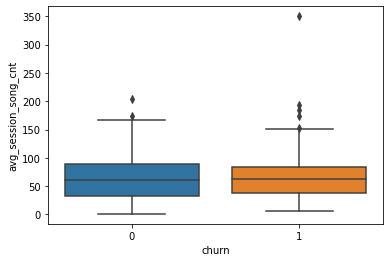

In [29]:
print(user_df_pd.groupby('churn')['avg_session_song_cnt'].agg('mean'))
sns.boxplot(x='churn', y='avg_session_song_cnt', data=user_df_pd);

Churners listened about the same number of songs per session. Most likely it will not be a predictive feature for churn

churn
0    55.948424
1    43.434343
Name: thumbs_up, dtype: float64


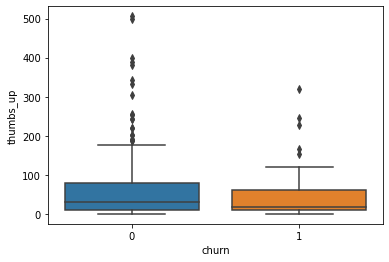

In [24]:
print(user_df_pd.groupby('churn')['thumbs_up'].agg('mean'))
sns.boxplot(x='churn', y='thumbs_up', data=user_df_pd);

Churners gave less 'thumbs up' rating comparing to non-churners

churn
0    18.767908
1    15.525253
Name: add_friend, dtype: float64


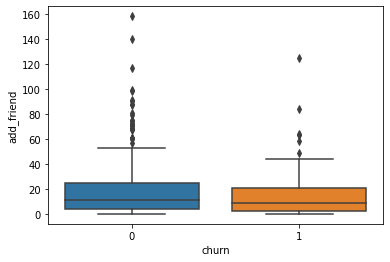

In [25]:
print(user_df_pd.groupby('churn')['add_friend'].agg('mean'))
sns.boxplot(x='churn', y='add_friend', data=user_df_pd);

Additionally, churners were not adding friends as often as non-churners

churn
0    8.538682
1    8.393939
Name: downgrade, dtype: float64


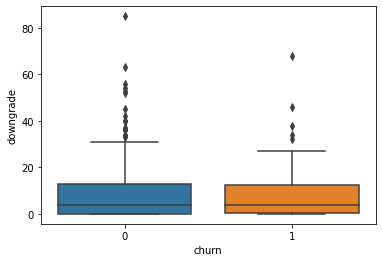

In [26]:
print(user_df_pd.groupby('churn')['downgrade'].agg('mean'))
sns.boxplot(x='churn', y='downgrade', data=user_df_pd);

Interestingly, churners were downgrading as often as non-churners

In [34]:
user_df_pd.groupby('paid')['churn'].value_counts(normalize=True)

paid  churn
0     0        0.811024
      1        0.188976
1     0        0.766355
      1        0.233645
Name: churn, dtype: float64

23% of churners were paying for the service vs. 19% non-churners.

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [27]:
from pyspark.ml import Pipeline, PipelineModel

from pyspark.ml.classification import LogisticRegression, GBTClassifier, GBTClassificationModel, RandomForestClassifier, RandomForestClassificationModel
from pyspark.ml.feature import StandardScaler, VectorAssembler, SQLTransformer, Imputer 
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [28]:
user_df.printSchema()

root
 |-- userId: string (nullable = true)
 |-- churn: integer (nullable = true)
 |-- start_dt: string (nullable = true)
 |-- end_dt: string (nullable = true)
 |-- views_cnt: long (nullable = false)
 |-- visits_cnt: long (nullable = false)
 |-- paid: integer (nullable = false)
 |-- all_artists_cnt: long (nullable = false)
 |-- tenure: integer (nullable = true)
 |-- avg_session_song_cnt: double (nullable = true)
 |-- avg_session_duriation_hr: double (nullable = true)
 |-- avg_song_length: double (nullable = true)
 |-- freq: double (nullable = true)
 |-- thumbs_up: long (nullable = true)
 |-- add_to_playlist: long (nullable = true)
 |-- add_friend: long (nullable = true)
 |-- thumbs_down: long (nullable = true)
 |-- upgrade: long (nullable = true)
 |-- downgrade: long (nullable = true)
 |-- rol_advert: long (nullable = true)
 |-- help: long (nullable = true)
 |-- settings: long (nullable = true)



In [29]:
label = 'churn'
feature_cols = user_df.columns[4:]
print(feature_cols)

['views_cnt', 'visits_cnt', 'paid', 'all_artists_cnt', 'tenure', 'avg_session_song_cnt', 'avg_session_duriation_hr', 'avg_song_length', 'freq', 'thumbs_up', 'add_to_playlist', 'add_friend', 'thumbs_down', 'upgrade', 'downgrade', 'rol_advert', 'help', 'settings']


In [30]:
# Convert all numeric columns to double
for feature in feature_cols:
    user_df = user_df.withColumn(feature, user_df[feature].cast("double"))

In [31]:
# Split between train and test
df_train, df_test = user_df.randomSplit([0.7,0.3], seed=42)

In [32]:
imputed_columns = ['IMP_'+col for col in feature_cols]

imputer = Imputer(inputCols=feature_cols, outputCols=imputed_columns, strategy='median')

assembler = VectorAssembler(inputCols=imputed_columns, outputCol="features")

lr =  LogisticRegression(featuresCol = 'features', labelCol=label, maxIter=10)

pipeline = Pipeline(stages=[imputer, assembler, lr])

In [33]:
lr_model = pipeline.fit(df_train)
train_predict = lr_model.transform(df_train)
test_predict = lr_model.transform(df_test)

In [34]:
# save model
lr_model.write().overwrite().save("lr_churn_pipeline")

In [35]:
# Evaluate model
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol=label)
print("Logistic Regression train score: ", evaluator.evaluate(train_predict))
print("Logisti score: ", evaluator.evaluate(test_predict))

Logistic Regression train score:  0.8741111829347118
Logisti score:  0.8442728442728449


In [36]:
# Explore the top predictors
m = lr_model.stages[2]
feature_importance = zip(m.coefficients, feature_cols)
# source how to sort list https://www.geeksforgeeks.org/python-ways-to-sort-a-zipped-list-by-values/
res = sorted(feature_importance, key = lambda x: x[0], reverse=True) 
print(res)

[(0.6647204995137651, 'paid'), (0.07318447849491104, 'upgrade'), (0.06363241572297225, 'avg_session_duriation_hr'), (0.02503367595705721, 'rol_advert'), (0.018673550295815966, 'thumbs_down'), (0.01590727459698349, 'downgrade'), (0.006089164362501742, 'avg_song_length'), (0.005285725464596032, 'avg_session_song_cnt'), (0.0006166972329346713, 'settings'), (-6.926904386326438e-07, 'views_cnt'), (-3.891440269658458e-05, 'all_artists_cnt'), (-0.00020738392760370988, 'help'), (-0.00085064081088193, 'add_friend'), (-0.0017876542805600449, 'thumbs_up'), (-0.002464442576109548, 'visits_cnt'), (-0.00407259168758967, 'add_to_playlist'), (-0.06831290907873483, 'tenure'), (-0.19321786103221483, 'freq')]


<AxesSubplot:xlabel='importance', ylabel='feature'>

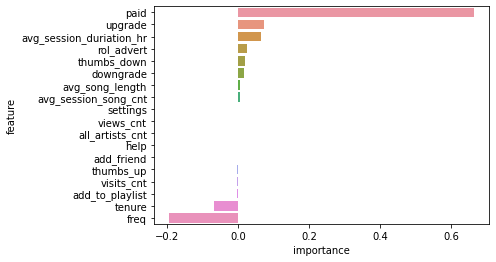

In [37]:
df = pd.DataFrame(res, columns=['importance','feature'])
sns.barplot(data=df, x='importance', y='feature')

From the feature importance coefficients, we can see that paid subscription, number of upgrades and average session duration are positively correlated with churn while visit frequency and tenure have negative correlation with churn

# Model tuning and selection

We will try other modeling algorithms such as boosted decision trees to try to improve the performance. We will also try to further improve the model by tuning the hyperparameters.

In [51]:
# Try GBT model
gbt = GBTClassifier(featuresCol = 'features', labelCol=label)
pipeline = Pipeline(stages=[imputer, assembler, gbt])

In [52]:
gbt_model = pipeline.fit(df_train)
train_predict_gbt = gbt_model.transform(df_train)
test_predict_gbt = gbt_model.transform(df_test)

In [79]:
print("GBT train score: ", evaluator.evaluate(train_predict))
print("GBT test score: ", evaluator.evaluate(test_predict))

GBT train score:  0.9999999999999998
GBT test score:  0.8110253110253115


Gradient Boosted Tree classifier showed a good result on the train data with the large drop in accuracy on test.
To reduce overfitting, we can tune the paramters. However, since logistic regression showed good performance, the better solution will be to go with the simpler model. We can further optimize it with the model tuning

In [102]:
# Adding a class weight since we are dealing with imbalanced data
# source: https://medium.com/@dhiraj.p.rai/logistic-regression-in-spark-ml-8a95b5f5434c
weightRatio= df_train.filter('churn==1').count()/df_train.count()
print(weightRatio)

0.2468354430379747


In [105]:
df_train=df_train.withColumn("classWeights", when(df_train.churn == 0,weightRatio).otherwise(1-weightRatio))

In [106]:
lr =  LogisticRegression(featuresCol = 'scaledFeatures', labelCol=label, maxIter=10, weightCol="classWeights")
pipeline = Pipeline(stages=[imputer, assembler, scaler, lr])

In [107]:
lr_model = pipeline.fit(df_train)
train_predict = lr_model.transform(df_train)
test_predict = lr_model.transform(df_test)

In [108]:
# Evaluate model
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol=label)
print("Logistic Regression train score: ", evaluator.evaluate(train_predict))
print("Logistic score: ", evaluator.evaluate(test_predict))

Logistic Regression train score:  0.8785283344106875
Logisti score:  0.8670098670098678


In [110]:
# To try to improve the model further, I will change other parameter values such as 
# regularization, number of iterations, elastic net and aggregation depth

from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [113]:
paramGrid = ParamGridBuilder() \
    .addGrid(lr.maxIter,[10,50,100]) \
    .addGrid(lr.regParam,[0.0, 0.1]) \
    .addGrid(lr.elasticNetParam,[0.0,0.5,1.0]) \
    .addGrid(lr.aggregationDepth,[2, 5, 10]) \
    .build()

In [114]:
# Adding 3-fold cross validation
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=3)
# Run cross validation
cv_model = crossval.fit(df_train)

In [115]:
train_predict = cv_model.transform(df_train)
test_predict = cv_model.transform(df_test)

In [116]:
print("Train score after tuning: ", evaluator.evaluate(train_predict))
print("Test score after tuning: ", evaluator.evaluate(test_predict))

Train score after tuning:  0.878528334410687
Test score after tuning:  0.8670098670098677


In [119]:
# what params performed the best

results = [
    (
        [
            {key.name: paramValue} 
            for key, paramValue 
            in zip(
                params.keys(), 
                params.values())
        ], metric
    ) 
    for params, metric 
    in zip(
        cv_model.getEstimatorParamMaps(), 
        cv_model.avgMetrics
    )
]

sorted(results, 
       key=lambda el: el[1], 
       reverse=True)[0]

([{'maxIter': 10},
  {'regParam': 0.0},
  {'elasticNetParam': 0.0},
  {'aggregationDepth': 5}],
 0.8729973369498643)

# Conclusion

I primarily used Spark libraries for data cleaning, analysis, modeling and evaluation. I ended up using medium data set. While initial data had over 600K rows, after aggregating on the user level, the resulting data had 99 churners and 349 non-churners. At this point, it would be easier to use Python scikit learn libraries. However, I decided to proceed with the Spark machine learning libraries to satisfy the project requirements.

The Logistic regression classifier was the most effective for this problem. Additional tuning showed slight improvement in test data. The resulting model performance showed 0.8785 AUC on the train and 0.8670 on the test data. This is reasonably good performance given very small training set. Train and test performance metrics is also close that indicate that the model may generalize well on a new dataset as well. Ideally, we should test on the hold out sample after we tune the model. I skipped this steps given small data set and relied on cross validation approach instead.

If we need to tune it further, I suggest to generate features based on the order of interactions to pick up signals of when a user loses interest in the services. This will allow us to timely predict the churn event.